In [2]:
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

In [9]:
def pdf_to_cdf(x_grid,kde):
    kde = kde.evaluate(x_grid)
    cdf = np.cumsum(kde)
    cdf = cdf / cdf[-1]
    return cdf

In [4]:
def EDA_calc (data, metric='euclidean'):
    L, W = data.shape
    EDA = {}
    
    dist = cdist(data, data, metric=metric)
    
    EDA['Centrality'] = 1/np.sum(dist,axis=0)
    EDA['CumulativeProximity'] = np.sum(dist**2,axis=0)
    EDA['SquareCentrality'] = 1/EDA['CumulativeProximity']
    EDA['Eccentricity'] = 2*EDA['CumulativeProximity']/np.sum(EDA['CumulativeProximity'])
    EDA['Density'] = L/EDA['Eccentricity']    
    
    return EDA

In [5]:
##########################################################
# ------------------------------------------------------ #
# ----------------------- LOADING ---------------------- #
# ------------------------------------------------------ #
##########################################################
# Firstly the model loads the background and signal data, 
# then it removes the attributes first string line, which 
# are the column names, in order to avoid NaN values in 
# the array.

print('         ==== Commencing Initiation ====\n')

### Background
b_name='Input_Background_1.csv'
background = np.genfromtxt(b_name, delimiter=',')
background = background[1:,:]
Lb, W = background.shape
print("     .Background Loaded..." )
print("     .Background shape: {}".format(background.shape))

### Signal
s_name='Input_Signal_1.csv'
signal = np.genfromtxt(s_name, delimiter=',')
signal = signal[1:,:]
Ls, _ = signal.shape
print("     .Signal Loaded...")
print("     .Signal shape: {}\n".format(signal.shape))

print('\n          ==== Initiation Complete ====\n')
print('=*='*17 )
print('      ==== Commencing Data Processing ====')

         ==== Commencing Initiation ====

     .Background Loaded...
     .Background shape: (543500, 21)
     .Signal Loaded...
     .Signal shape: (522467, 21)


          ==== Initiation Complete ====

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
      ==== Commencing Data Processing ====


In [6]:
##########################################################
# ------------------------------------------------------ #
# --------------------- INITIATION --------------------- #
# ------------------------------------------------------ #
##########################################################
### Define User Variables ###

# List of Granularities
gra_list = [i for i in range(1,11)]

# Number of Iterations
iterations = 1

# Number of events
total = 10000

# Number of Data-set divisions
windows = 334

# Percentage of background samples on the testing phase
background_percent = 0.99

# Percentage of samples on the training phase
test_size = 0.3

# Percentage of background samples to divide the data-set
dat_set_percent = total/len(background)


In [15]:
for n_i in range(iterations):
    print('\n     => Iteration Number', (n_i+1) )

    # Divide data-set into training and testing sub-sets
    print('         .Dividing training and testing sub-sets')

    _,reduced_background = train_test_split(background, test_size=dat_set_percent)

    background_seed, streaming_background = train_test_split(reduced_background, test_size=test_size)
    
    n_signal_samples = len(streaming_background)*(1-background_percent)

    _,streaming_background = train_test_split(streaming_background, test_size=background_percent)
    
    # Defining number of events Signal events on online phase.
    _,reduced_signal = train_test_split(signal, test_size=n_signal_samples/len(signal))

    # Concatenating Signal and the Test Background sub-set
    streaming_data = np.vstack((streaming_background,reduced_signal))
    
    n_bd_str = len(streaming_background)
    n_sl_str = len(reduced_signal)

    print("             .Seed shape: {}".format(background_seed.shape))
    print("             .Streaming shape: {}\n".format(streaming_data.shape))
    print("             .Streaming Background shape: {}\n".format(streaming_background.shape))
    print("             .Streaming Signal shape: {}\n".format(reduced_signal.shape))

    # Normalize Data
    print('         .Normalizing Data')
    streaming_data = normalize(streaming_data,norm='max',axis=0)
    background_seed = normalize(background_seed,norm='max',axis=0)
    
    # Concatenating Signal and the Test Background sub-set
    total_data = np.vstack((background_seed,streaming_data))

    reduced_signal = streaming_data[n_bd_str:n_bd_str+n_sl_str,:]
    ### Create target

    y =np.ones((len(streaming_data)))
    y[len(streaming_background):] = -1
    y[len(background_seed):] = 0


     => Iteration Number 1
         .Dividing training and testing sub-sets
             .Seed shape: (7000, 21)
             .Streaming shape: (3001, 21)

             .Streaming Background shape: (2970, 21)

             .Streaming Signal shape: (31, 21)

         .Normalizing Data


# Original Attributes

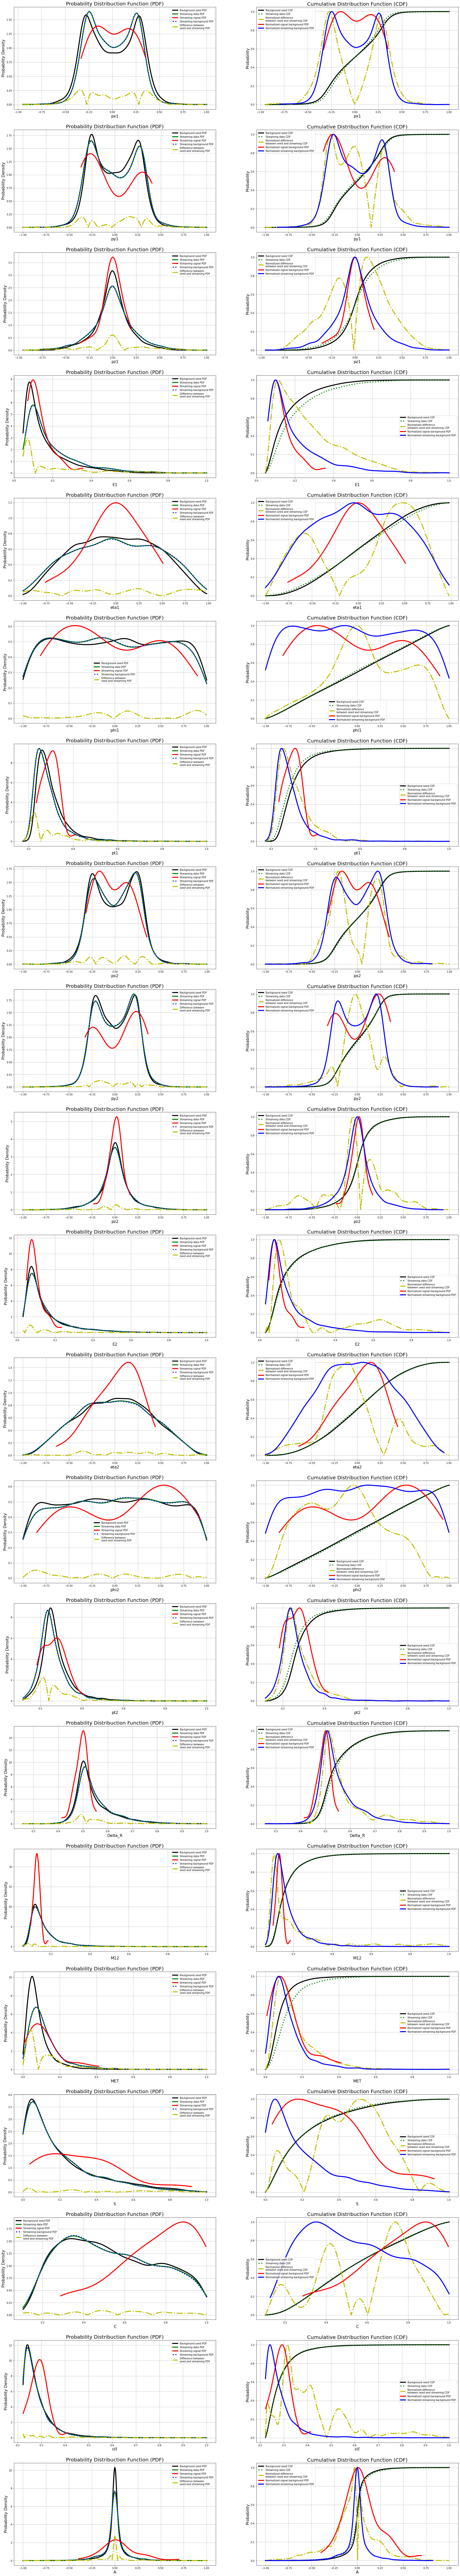

In [26]:
attributes= ["px1","py1","pz1","E1","eta1","phi1","pt1","px2","py2","pz2","E2",
             "eta2","phi2","pt2","Delta_R","M12","MET","S","C","HT","A"]

fig = plt.figure(figsize=[32,9*len(background_seed[0,:])])
ax = fig.subplots(len(background_seed[0,:]),2)

for i, att in enumerate(attributes):
    seed_var = background_seed[:,i]
    streaming_var = streaming_data[:,i]
    
    signal_streaming_var = streaming_var[n_bd_str:n_bd_str+n_sl_str]
    background_streaming_var = streaming_var[:n_bd_str]
    
    signal_streaming_var = np.sort(signal_streaming_var)
    background_streaming_var = np.sort(background_streaming_var)

    seed_kde = stats.gaussian_kde(seed_var)
    streaming_kde = stats.gaussian_kde(streaming_var)
    signal_kde = stats.gaussian_kde(signal_streaming_var)
    background_kde = stats.gaussian_kde(background_streaming_var)
    
    data_eval = np.linspace(min([min(seed_var),min(streaming_var)]),
                            max([max(seed_var),max(streaming_var)]), 
                            2000)
    background_eval = np.linspace(min(background_streaming_var),
                            max(background_streaming_var), 
                            1000)
    signal_eval = np.linspace(min(signal_streaming_var),
                            max(signal_streaming_var), 
                            1000)
    
    seed_cdf = pdf_to_cdf(data_eval,seed_kde)
    streaming_cdf = pdf_to_cdf(data_eval,streaming_kde)

    # Plot the Probability Distribuction Function (PDF)
    
    ax[i,0].set_ylabel('Probability Density',fontsize=16)
    ax[i,0].set_xlabel(att,fontsize=16)
    ax[i,0].set_title('Probability Distribuction Function (PDF)',fontsize=20)
        
    ax[i,0].plot(data_eval, seed_kde(data_eval), 'k', linewidth=4, label='Background seed PDF')
    ax[i,0].plot(data_eval, streaming_kde(data_eval),'g', linewidth=4, label='Streaming data PDF')
    ax[i,0].plot(signal_eval, signal_kde(signal_eval),'r', linewidth=4, label='Streaming signal PDF')
    ax[i,0].plot(background_eval, background_kde(background_eval),':b', linewidth=4, label='Streaming background PDF')
    ax[i,0].plot(data_eval, np.sqrt((seed_kde(data_eval) - streaming_kde(data_eval))**2),'-.y', 
            linewidth=4, label='Difference between\nseed and streaming PDF')

    ax[i,0].grid()
    ax[i,0].legend()
    
    # Plot the Cumulative Distribuction Function (CDF)
    
    ax[i,1].set_ylabel('Probability',fontsize=16)
    ax[i,1].set_xlabel(att,fontsize=16)
    ax[i,1].set_title('Cumulative Distribuction Function (CDF)',fontsize=20)    
    
    ax[i,1].plot(data_eval, seed_cdf, 'k', linewidth=4, label='Background seed CDF')
    ax[i,1].plot(data_eval, streaming_cdf,':g', linewidth=4, label='Streaming data CDF')
    ax[i,1].plot(data_eval,normalize(np.sqrt((seed_cdf - streaming_cdf)**2).reshape((1,-1)),
                                        norm='max').reshape((-1))
                 ,'-.y', linewidth=4, label='Normalized difference\nbetween seed and streaming CDF')
    ax[i,1].plot(signal_eval, normalize(signal_kde(signal_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'r', linewidth=4, label='Normalized signal background PDF')
    ax[i,1].plot(background_eval, normalize(background_kde(background_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'b', linewidth=4, label='Normalized streaming background PDF')
    ax[i,1].grid()
    ax[i,1].legend()
    
plt.show()
fig.savefig('Attributes_PDF&CDF.pdf', bbox_inches='tight')

#### EDA
>## Cosine

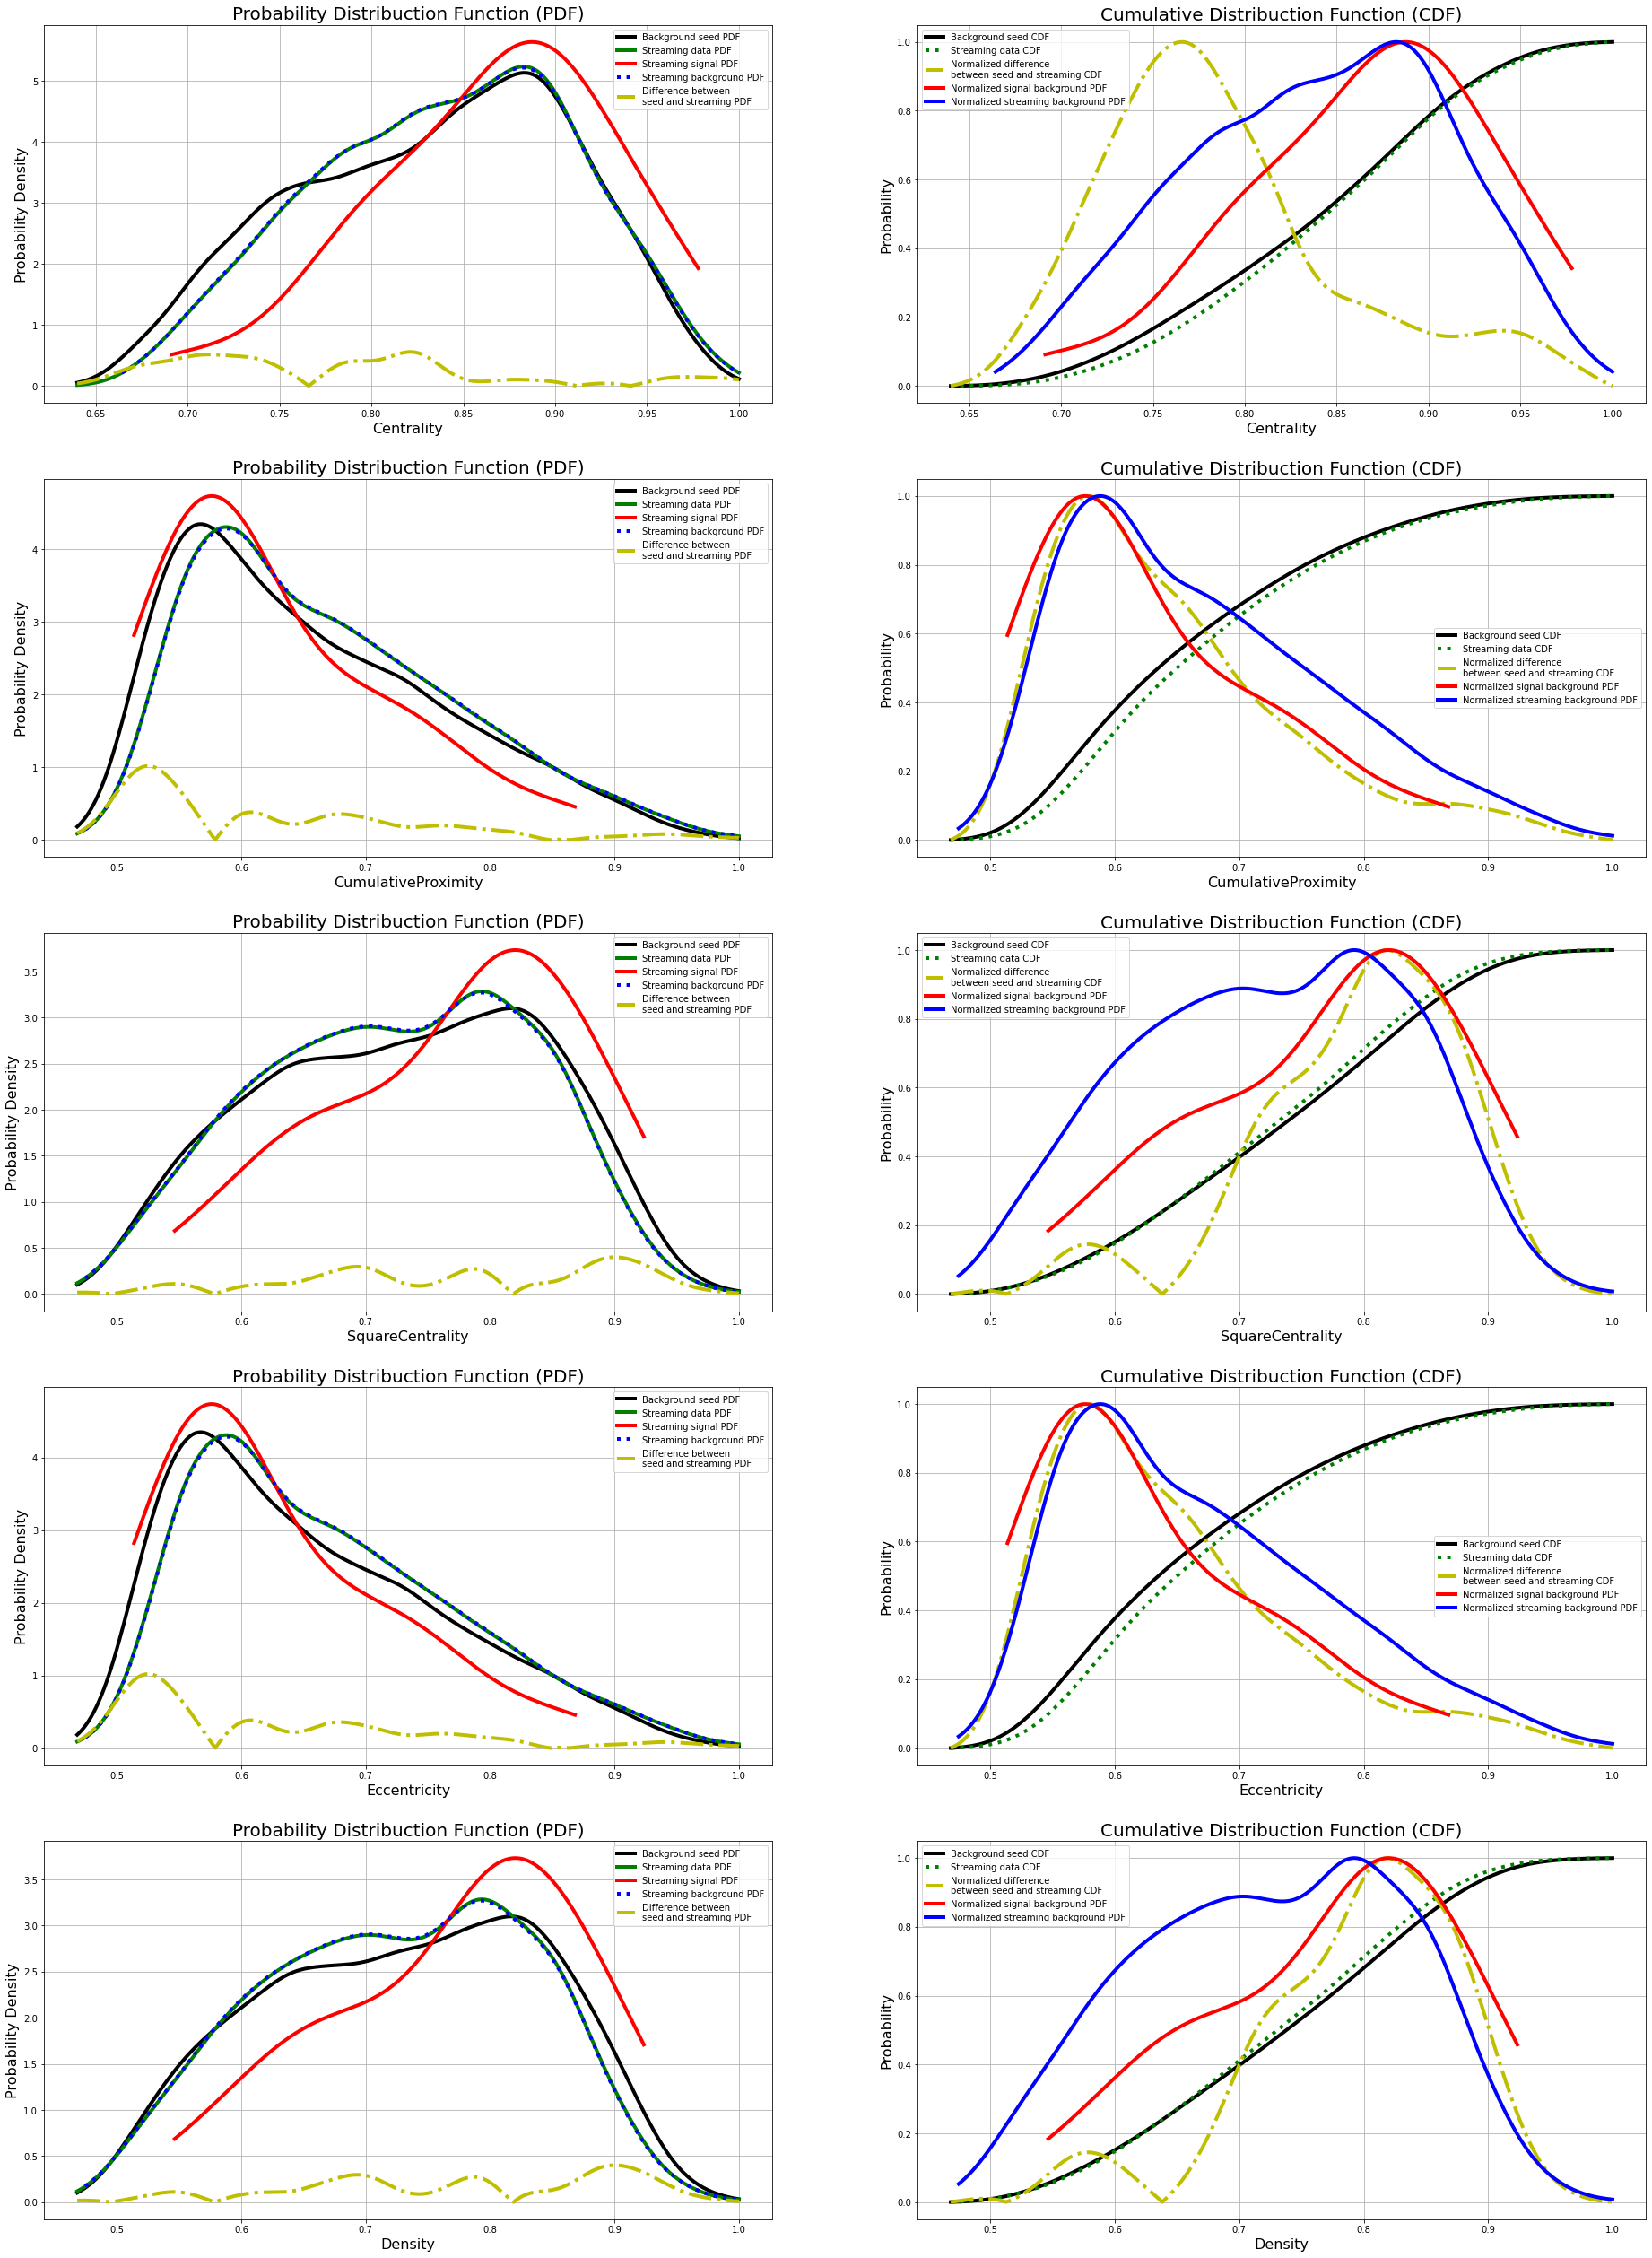

In [16]:
streaming_eda = EDA_calc(streaming_data,metric ='cosine')
seed_eda = EDA_calc(background_seed,metric ='cosine')

fig = plt.figure(figsize=[32,9*len(streaming_eda.keys())])
ax = fig.subplots(1*len(streaming_eda.keys()),2)

for i,eda in enumerate(streaming_eda):
    
    seed_var = seed_eda[eda]
    streaming_var = streaming_eda[eda]

    seed_var = normalize(seed_var.reshape((1,-1)),norm='max').reshape((-1))
    streaming_var = normalize(streaming_var.reshape((1,-1)),norm='max').reshape((-1))

    signal_streaming_var = streaming_var[n_bd_str:n_bd_str+n_sl_str]
    background_streaming_var = streaming_var[:n_bd_str]

    seed_kde = stats.gaussian_kde(seed_var)
    streaming_kde = stats.gaussian_kde(streaming_var)
    signal_kde = stats.gaussian_kde(signal_streaming_var)
    background_kde = stats.gaussian_kde(background_streaming_var)

    data_eval = np.linspace(min([min(seed_var),min(streaming_var)]),
                            max([max(seed_var),max(streaming_var)]), 
                            2000)
    background_eval = np.linspace(min(background_streaming_var),
                            max(background_streaming_var), 
                            1000)
    signal_eval = np.linspace(min(signal_streaming_var),
                            max(signal_streaming_var), 
                            1000)

    seed_cdf = pdf_to_cdf(data_eval,seed_kde)
    streaming_cdf = pdf_to_cdf(data_eval,streaming_kde)

    # Plot the Probability Distribuction Function (PDF)
    
    ax[i,0].set_ylabel('Probability Density',fontsize=16)
    ax[i,0].set_xlabel(eda,fontsize=16)
    ax[i,0].set_title('Probability Distribuction Function (PDF)',fontsize=20)

    ax[i,0].plot(data_eval, seed_kde(data_eval), 'k', linewidth=4, label='Background seed PDF')
    ax[i,0].plot(data_eval, streaming_kde(data_eval),'g', linewidth=4, label='Streaming data PDF')
    ax[i,0].plot(signal_eval, signal_kde(signal_eval),'r', linewidth=4, label='Streaming signal PDF')
    ax[i,0].plot(background_eval, background_kde(background_eval),':b', linewidth=4, 
                 label='Streaming background PDF')
    ax[i,0].plot(data_eval, np.sqrt((seed_kde(data_eval) - streaming_kde(data_eval))**2),'-.y', 
                linewidth=4, label='Difference between\nseed and streaming PDF')
    ax[i,0].grid()
    ax[i,0].legend()

    # Plot the Cumulative Distribuction Function (CDF)
    
    ax[i,1].set_ylabel('Probability',fontsize=16)
    ax[i,1].set_xlabel(eda,fontsize=16)
    ax[i,1].set_title('Cumulative Distribuction Function (CDF)',fontsize=20)
    
    ax[i,1].plot(data_eval, seed_cdf, 'k', linewidth=4, label='Background seed CDF')
    ax[i,1].plot(data_eval, streaming_cdf,':g', linewidth=4, label='Streaming data CDF')
    ax[i,1].plot(data_eval,normalize(np.sqrt((seed_cdf - streaming_cdf)**2).reshape((1,-1)),
                                        norm='max').reshape((-1))
                 ,'-.y', linewidth=4, label='Normalized difference\nbetween seed and streaming CDF')
    ax[i,1].plot(signal_eval, normalize(signal_kde(signal_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'r', linewidth=4, label='Normalized signal background PDF')
    ax[i,1].plot(background_eval, normalize(background_kde(background_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'b', linewidth=4, label='Normalized streaming background PDF')
    
    ax[i,1].grid()
    ax[i,1].legend()

plt.show()
fig.savefig('EDA_cosine_PDF&CDF.pdf', bbox_inches='tight')

> ## Euclidean

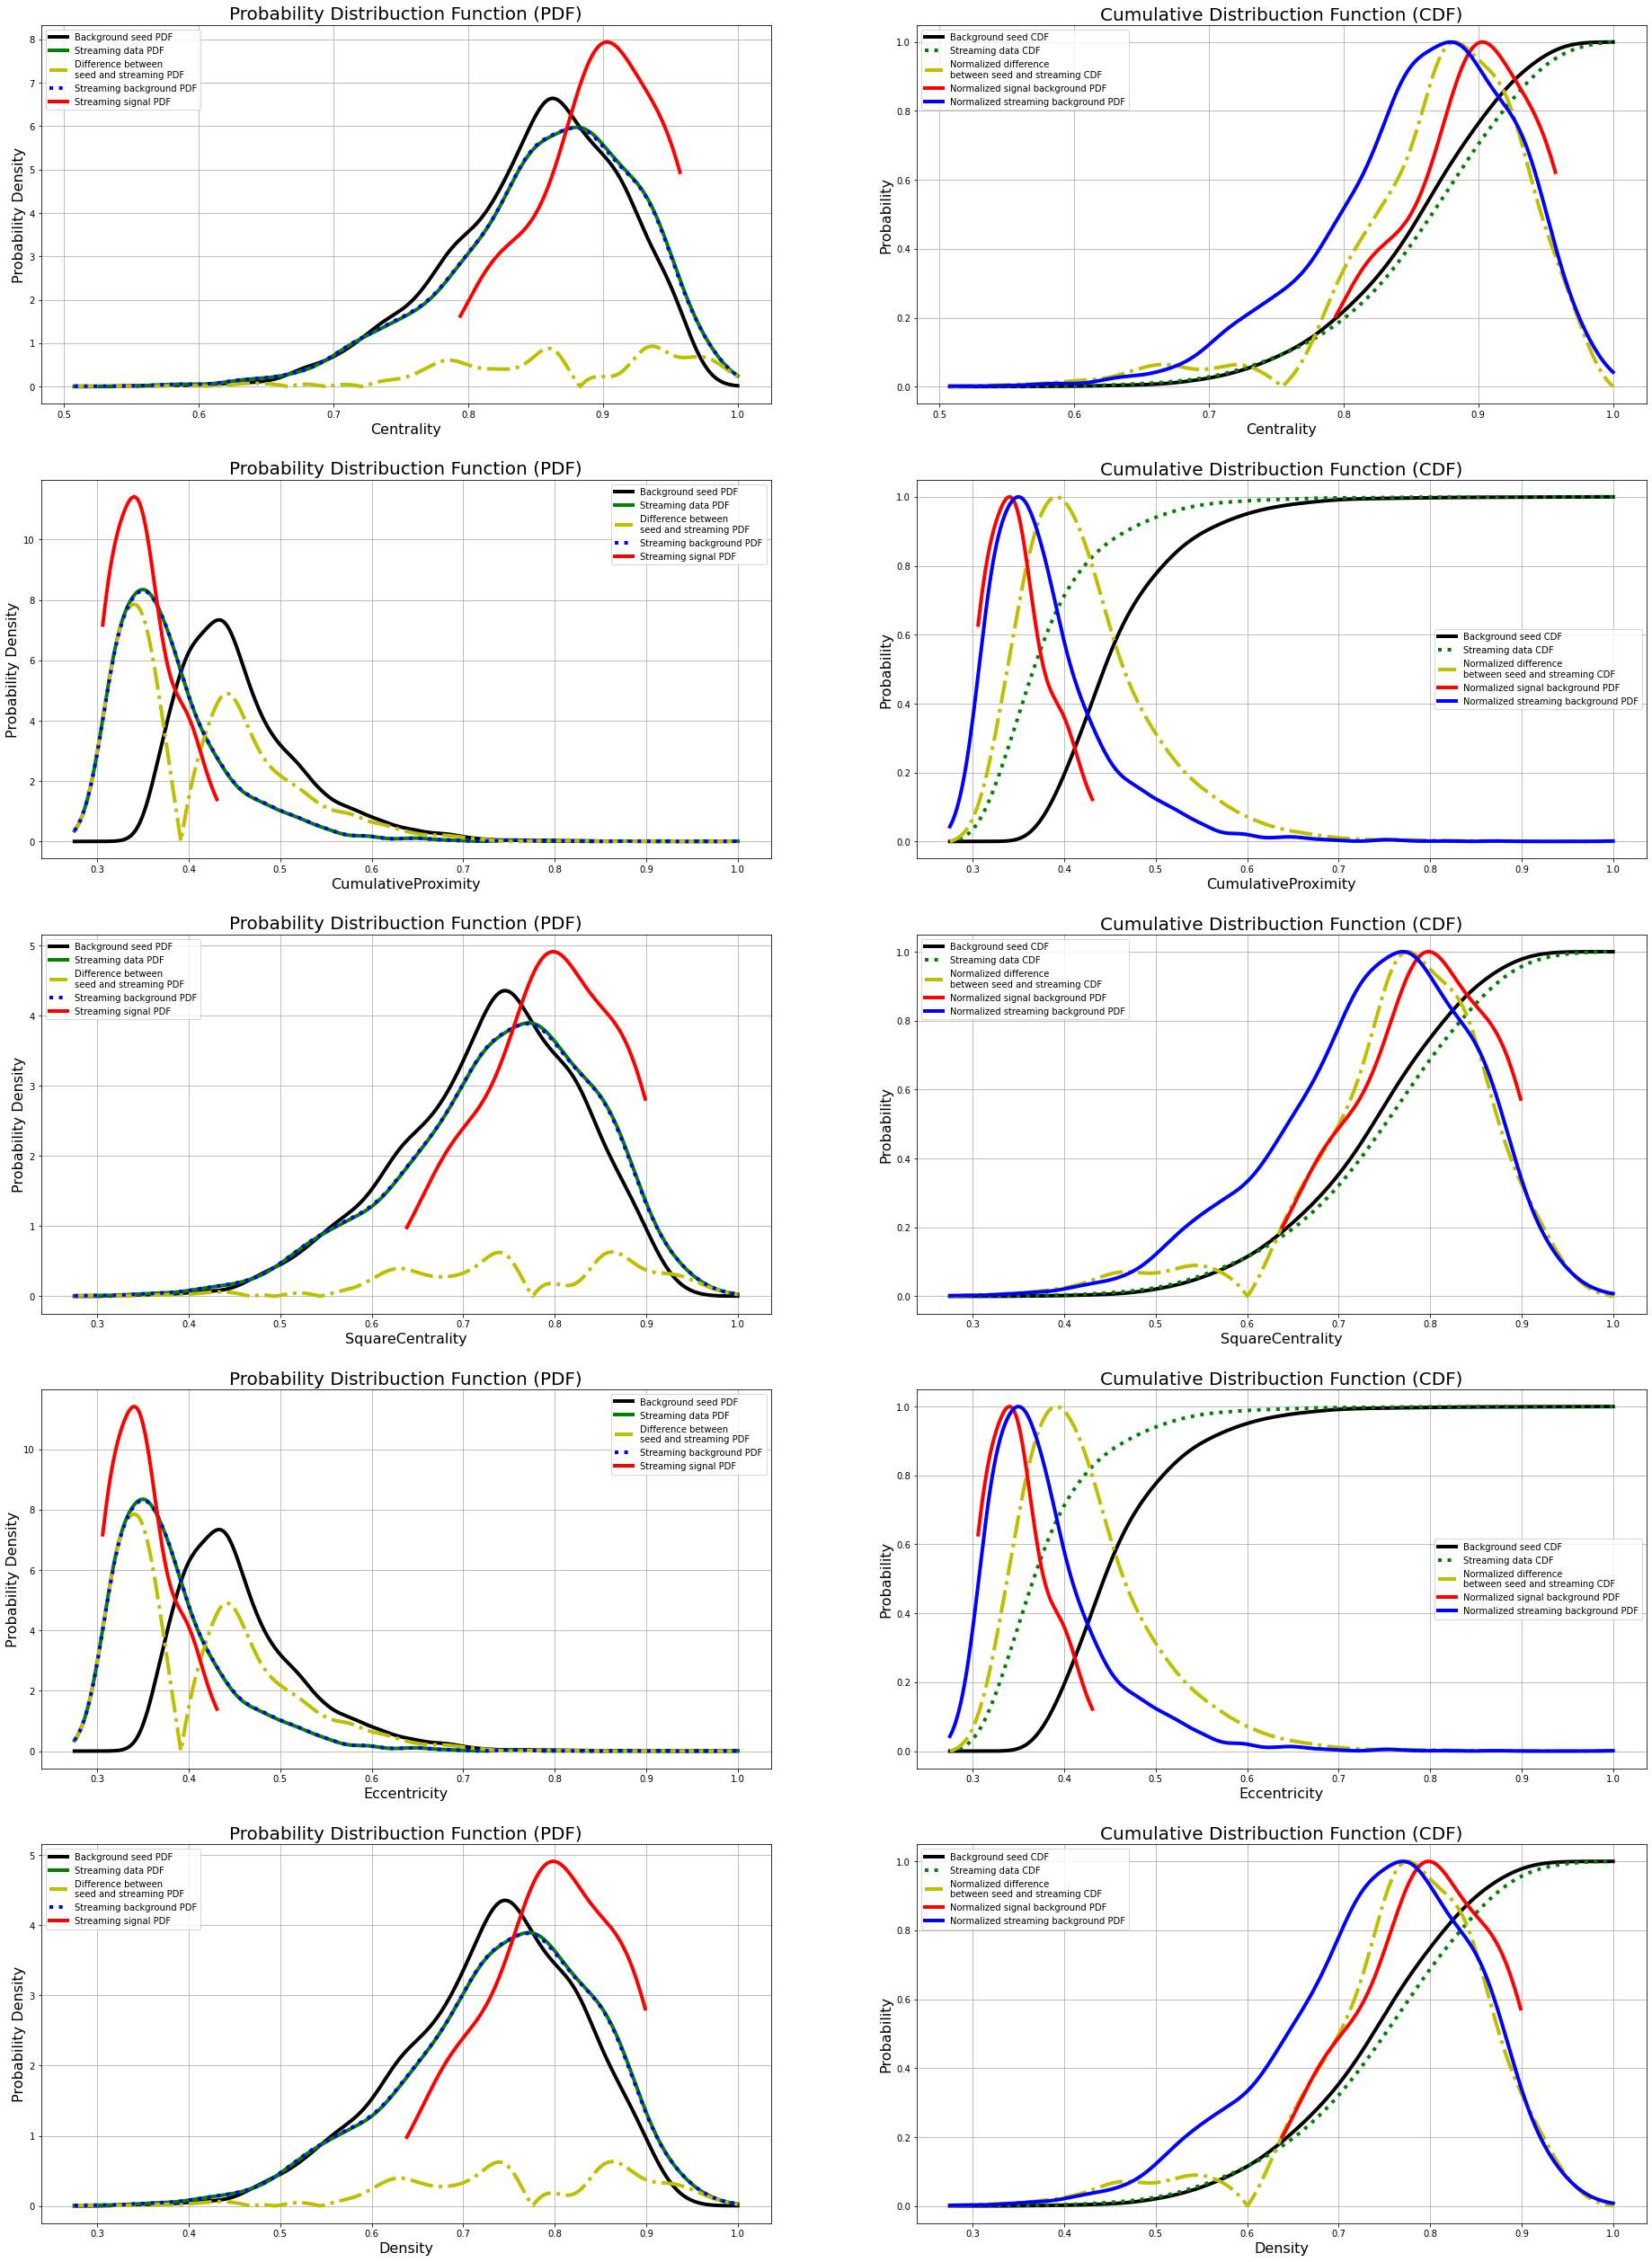

In [28]:
streaming_eda = EDA_calc(streaming_data)
seed_eda = EDA_calc(background_seed)

fig = plt.figure(figsize=[32,9*len(streaming_eda.keys())])
ax = fig.subplots(1*len(streaming_eda.keys()),2)

for i,eda in enumerate(streaming_eda):
    
    seed_var = seed_eda[eda]
    streaming_var = streaming_eda[eda]

    seed_var = normalize(seed_var.reshape((1,-1)),norm='max').reshape((-1))
    streaming_var = normalize(streaming_var.reshape((1,-1)),norm='max').reshape((-1))

    signal_streaming_var = streaming_var[n_bd_str:n_bd_str+n_sl_str]
    background_streaming_var = streaming_var[:n_bd_str]
    
    signal_streaming_var = np.sort(signal_streaming_var)
    background_streaming_var = np.sort(background_streaming_var)

    seed_kde = stats.gaussian_kde(seed_var)
    streaming_kde = stats.gaussian_kde(streaming_var)
    signal_kde = stats.gaussian_kde(signal_streaming_var)
    background_kde = stats.gaussian_kde(background_streaming_var)

    data_eval = np.linspace(min([min(seed_var),min(streaming_var)]),
                            max([max(seed_var),max(streaming_var)]), 
                            2000)
    background_eval = np.linspace(min(background_streaming_var),
                            max(background_streaming_var), 
                            1000)
    signal_eval = np.linspace(min(signal_streaming_var),
                            max(signal_streaming_var), 
                            1000)

    seed_cdf = pdf_to_cdf(data_eval,seed_kde)
    streaming_cdf = pdf_to_cdf(data_eval,streaming_kde)

    # Plot the Probability Distribuction Function (PDF)
    
    ax[i,0].set_ylabel('Probability Density',fontsize=16)
    ax[i,0].set_xlabel(eda,fontsize=16)
    ax[i,0].set_title('Probability Distribuction Function (PDF)',fontsize=20)

    ax[i,0].plot(data_eval, seed_kde(data_eval), 'k', linewidth=4, label='Background seed PDF')
    ax[i,0].plot(data_eval, streaming_kde(data_eval),'g', linewidth=4, label='Streaming data PDF')
    ax[i,0].plot(data_eval, np.sqrt((seed_kde(data_eval) - streaming_kde(data_eval))**2),'-.y', 
                linewidth=4, label='Difference between\nseed and streaming PDF')
    ax[i,0].plot(background_eval, background_kde(background_eval),':b', linewidth=4, 
                 label='Streaming background PDF')
    ax[i,0].plot(signal_eval, signal_kde(signal_eval),'r', linewidth=4, label='Streaming signal PDF')
    ax[i,0].grid()
    ax[i,0].legend()

    # Plot the Cumulative Distribuction Function (CDF)
    
    ax[i,1].set_ylabel('Probability',fontsize=16)
    ax[i,1].set_xlabel(eda,fontsize=16)
    ax[i,1].set_title('Cumulative Distribuction Function (CDF)',fontsize=20)

    ax[i,1].plot(data_eval, seed_cdf, 'k', linewidth=4, label='Background seed CDF')
    ax[i,1].plot(data_eval, streaming_cdf,':g', linewidth=4, label='Streaming data CDF')
    ax[i,1].plot(data_eval,normalize(np.sqrt((seed_cdf - streaming_cdf)**2).reshape((1,-1)),
                                        norm='max').reshape((-1))
                 ,'-.y', linewidth=4, label='Normalized difference\nbetween seed and streaming CDF')
    ax[i,1].plot(signal_eval, normalize(signal_kde(signal_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'r', linewidth=4, label='Normalized signal background PDF')
    ax[i,1].plot(background_eval, normalize(background_kde(background_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'b', linewidth=4, label='Normalized streaming background PDF')
    ax[i,1].grid()
    ax[i,1].legend()

plt.show()
fig.savefig('EDA_euclidean_PDF&CDF.pdf', bbox_inches='tight')

>## Mahalanobis

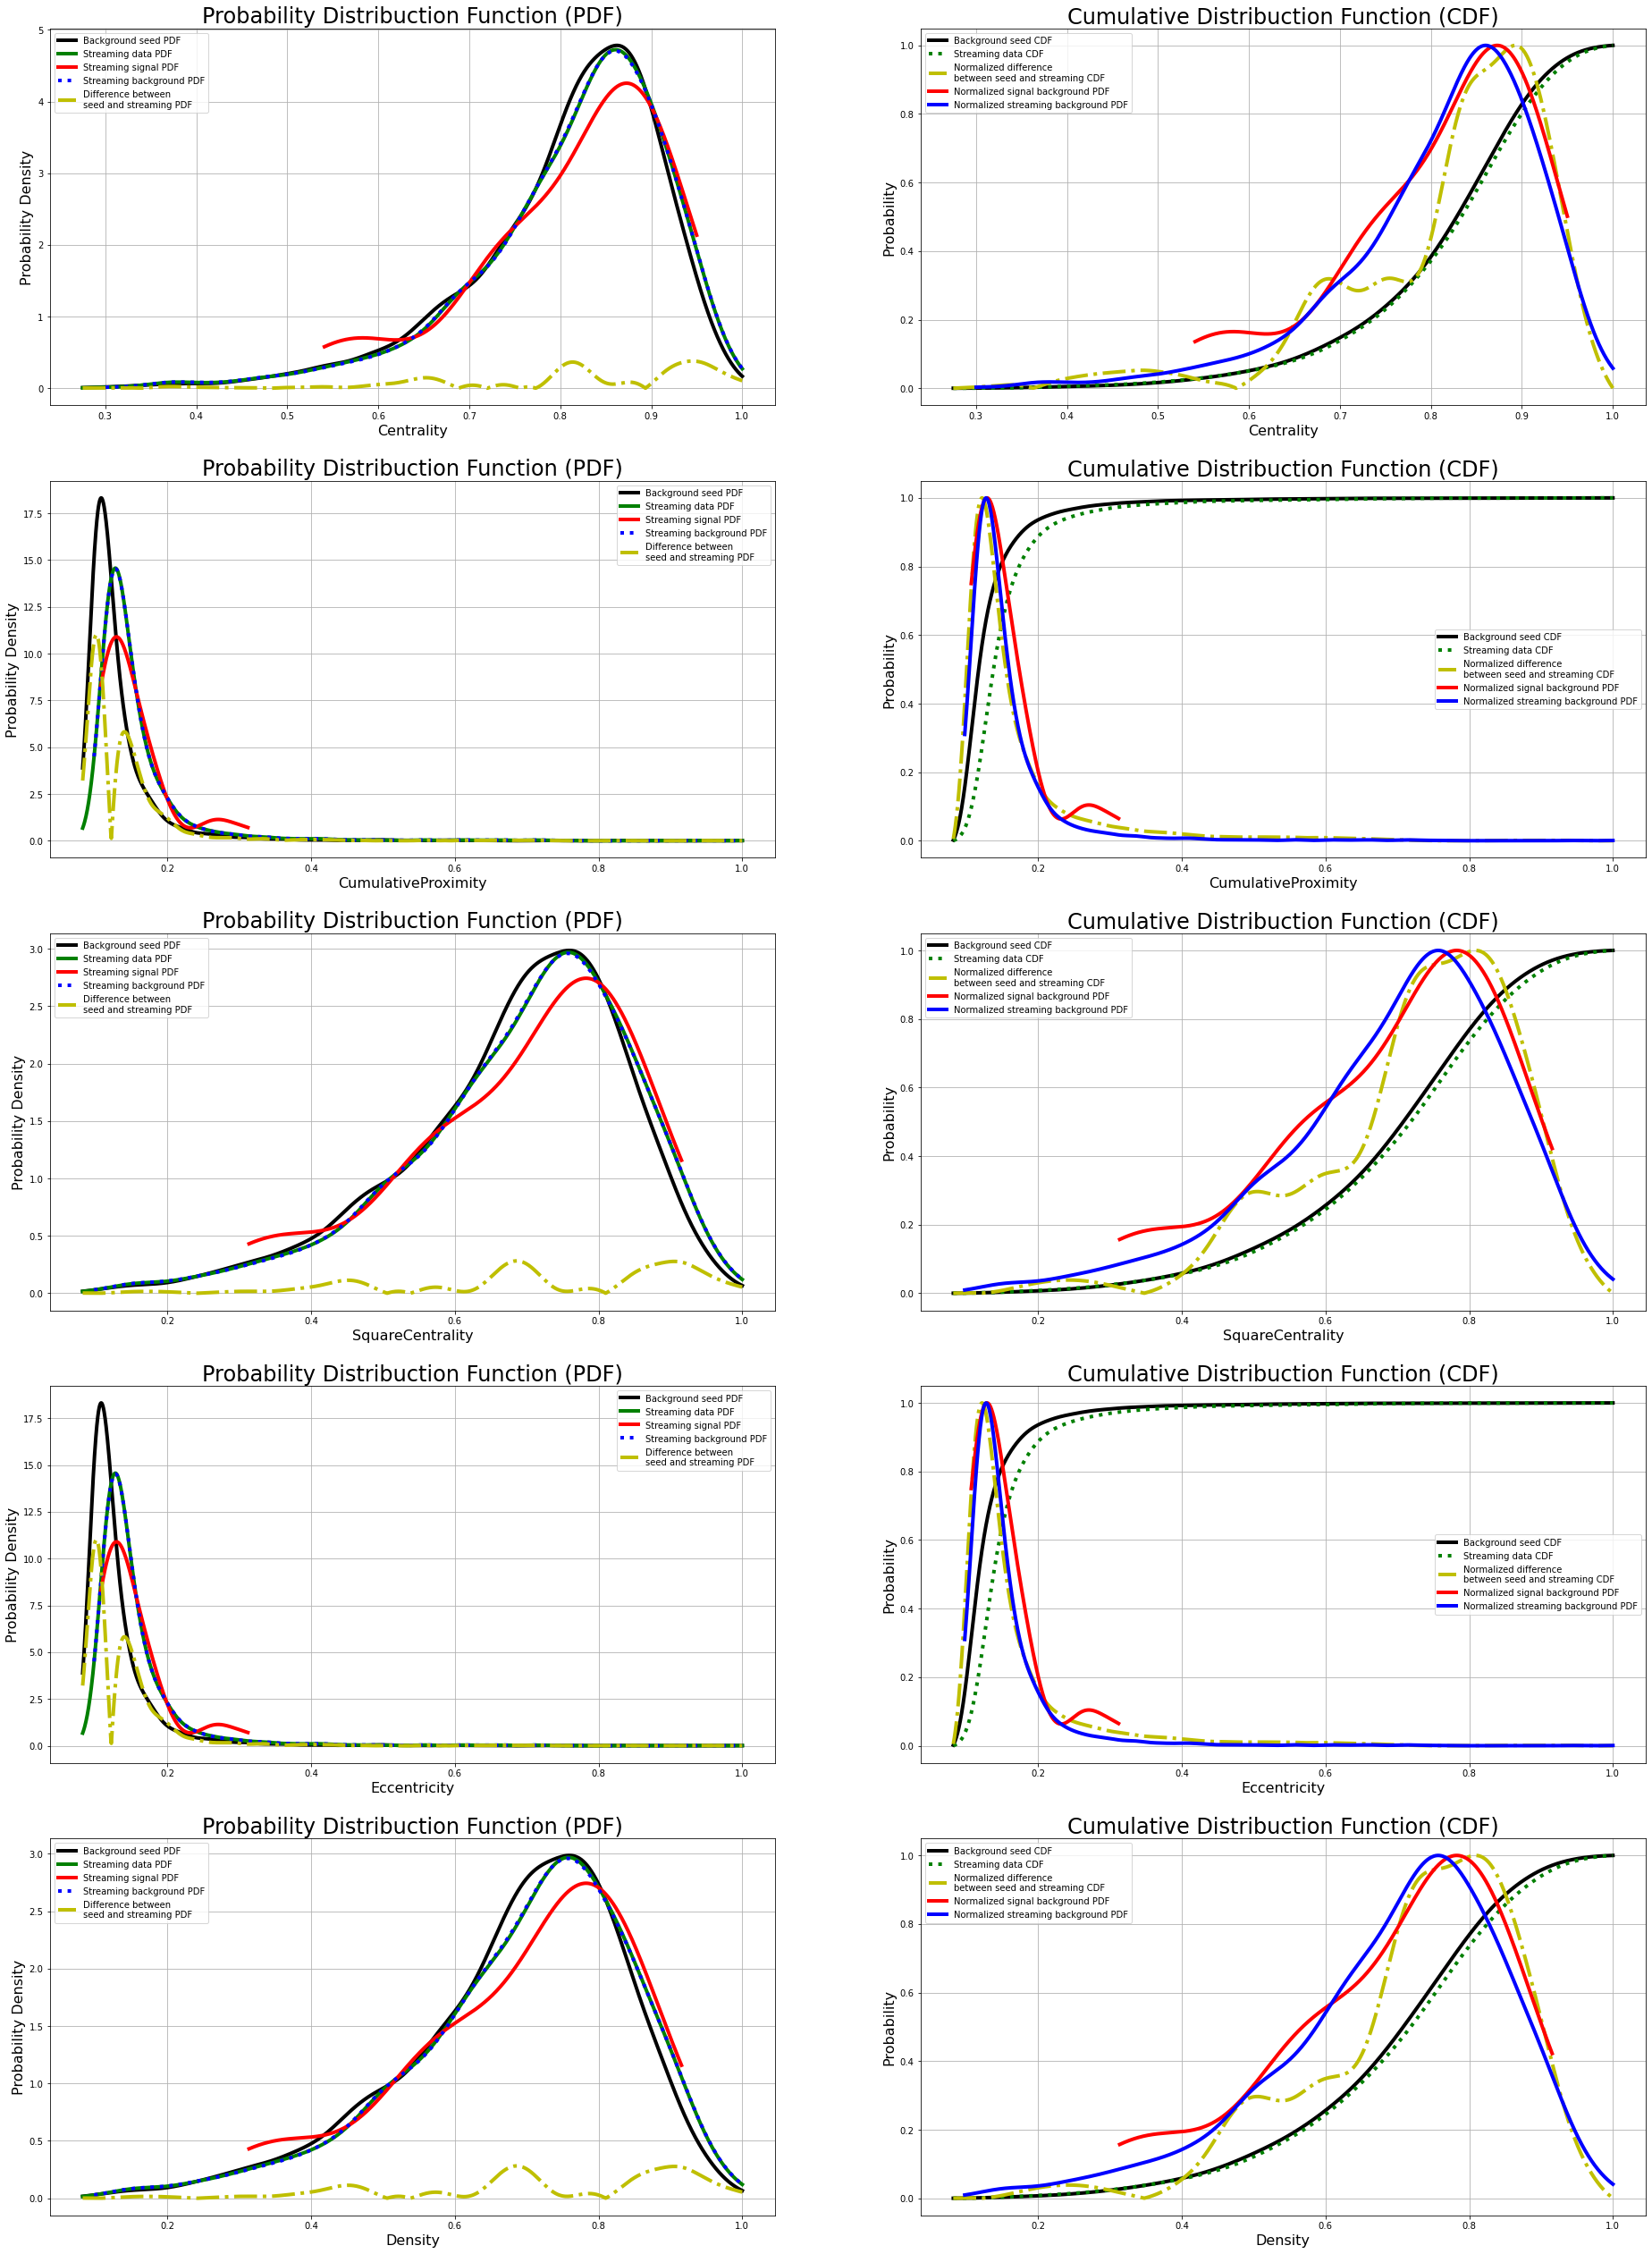

In [13]:
streaming_eda = EDA_calc(streaming_data,metric ='mahalanobis')
seed_eda = EDA_calc(background_seed,metric ='mahalanobis')

fig = plt.figure(figsize=[32,9*len(streaming_eda.keys())])
ax = fig.subplots(1*len(streaming_eda.keys()),2)

for i,eda in enumerate(streaming_eda):
    
    seed_var = seed_eda[eda]
    streaming_var = streaming_eda[eda]

    seed_var = normalize(seed_var.reshape((1,-1)),norm='max').reshape((-1))
    streaming_var = normalize(streaming_var.reshape((1,-1)),norm='max').reshape((-1))

    signal_streaming_var = streaming_var[n_bd_str:n_bd_str+n_sl_str]
    background_streaming_var = streaming_var[:n_bd_str]

    seed_kde = stats.gaussian_kde(seed_var)
    streaming_kde = stats.gaussian_kde(streaming_var)
    signal_kde = stats.gaussian_kde(signal_streaming_var)
    background_kde = stats.gaussian_kde(background_streaming_var)

    data_eval = np.linspace(min([min(seed_var),min(streaming_var)]),
                            max([max(seed_var),max(streaming_var)]), 
                            2000)
    background_eval = np.linspace(min(background_streaming_var),
                            max(background_streaming_var), 
                            1000)
    signal_eval = np.linspace(min(signal_streaming_var),
                            max(signal_streaming_var), 
                            1000)

    seed_cdf = pdf_to_cdf(data_eval,seed_kde)
    streaming_cdf = pdf_to_cdf(data_eval,streaming_kde)

    # Plot the Probability Distribuction Function (PDF)
    
    ax[i,0].set_ylabel('Probability Density',fontsize=16)
    ax[i,0].set_xlabel(eda,fontsize=16)
    ax[i,0].set_title('Probability Distribuction Function (PDF)',fontsize=24)
    
    ax[i,0].plot(data_eval, seed_kde(data_eval), 'k', linewidth=4, label='Background seed PDF')
    ax[i,0].plot(data_eval, streaming_kde(data_eval),'g', linewidth=4, label='Streaming data PDF')
    ax[i,0].plot(signal_eval, signal_kde(signal_eval),'r', linewidth=4, label='Streaming signal PDF')
    ax[i,0].plot(background_eval, background_kde(background_eval),':b', linewidth=4,
                 label='Streaming background PDF')
    ax[i,0].plot(data_eval, np.sqrt((seed_kde(data_eval) - streaming_kde(data_eval))**2),'-.y', 
                 linewidth=4, label='Difference between\nseed and streaming PDF')
    ax[i,0].grid()
    ax[i,0].legend()

    # Plot the Cumulative Distribuction Function (CDF)
    
    ax[i,1].set_ylabel('Probability',fontsize=16)
    ax[i,1].set_xlabel(eda,fontsize=16)
    ax[i,1].set_title('Cumulative Distribuction Function (CDF)',fontsize=24)
    
    ax[i,1].plot(data_eval, seed_cdf, 'k', linewidth=4, label='Background seed CDF')
    ax[i,1].plot(data_eval, streaming_cdf,':g', linewidth=4, label='Streaming data CDF')
    ax[i,1].plot(data_eval,normalize(np.sqrt((seed_cdf - streaming_cdf)**2).reshape((1,-1)),
                                        norm='max').reshape((-1))
                 ,'-.y', linewidth=4, label='Normalized difference\nbetween seed and streaming CDF')
    ax[i,1].plot(signal_eval, normalize(signal_kde(signal_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'r', linewidth=4, label='Normalized signal background PDF')
    ax[i,1].plot(background_eval, normalize(background_kde(background_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'b', linewidth=4, label='Normalized streaming background PDF')
    
    ax[i,1].grid()
    ax[i,1].legend()

plt.show()
fig.savefig('EDA_mahalanobis_PDF&CDF.pdf', bbox_inches='tight')

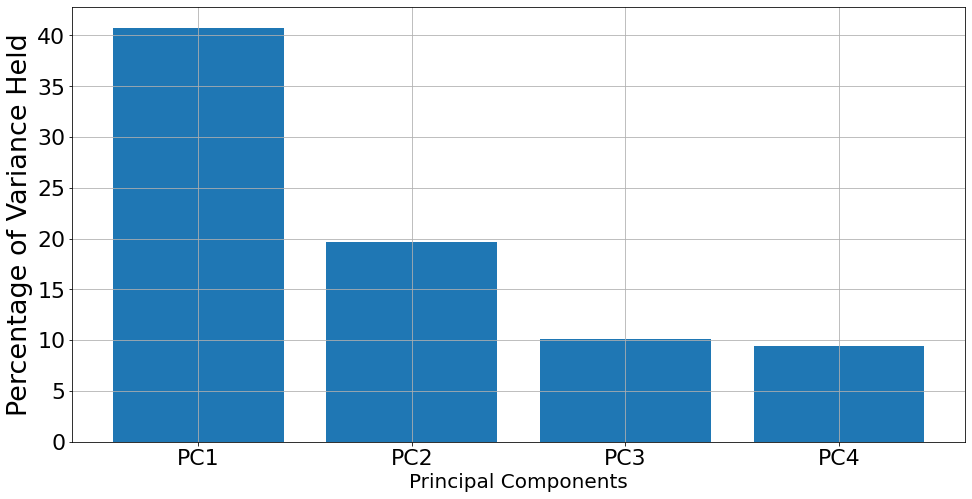

Variation maintained: 79.98
                  


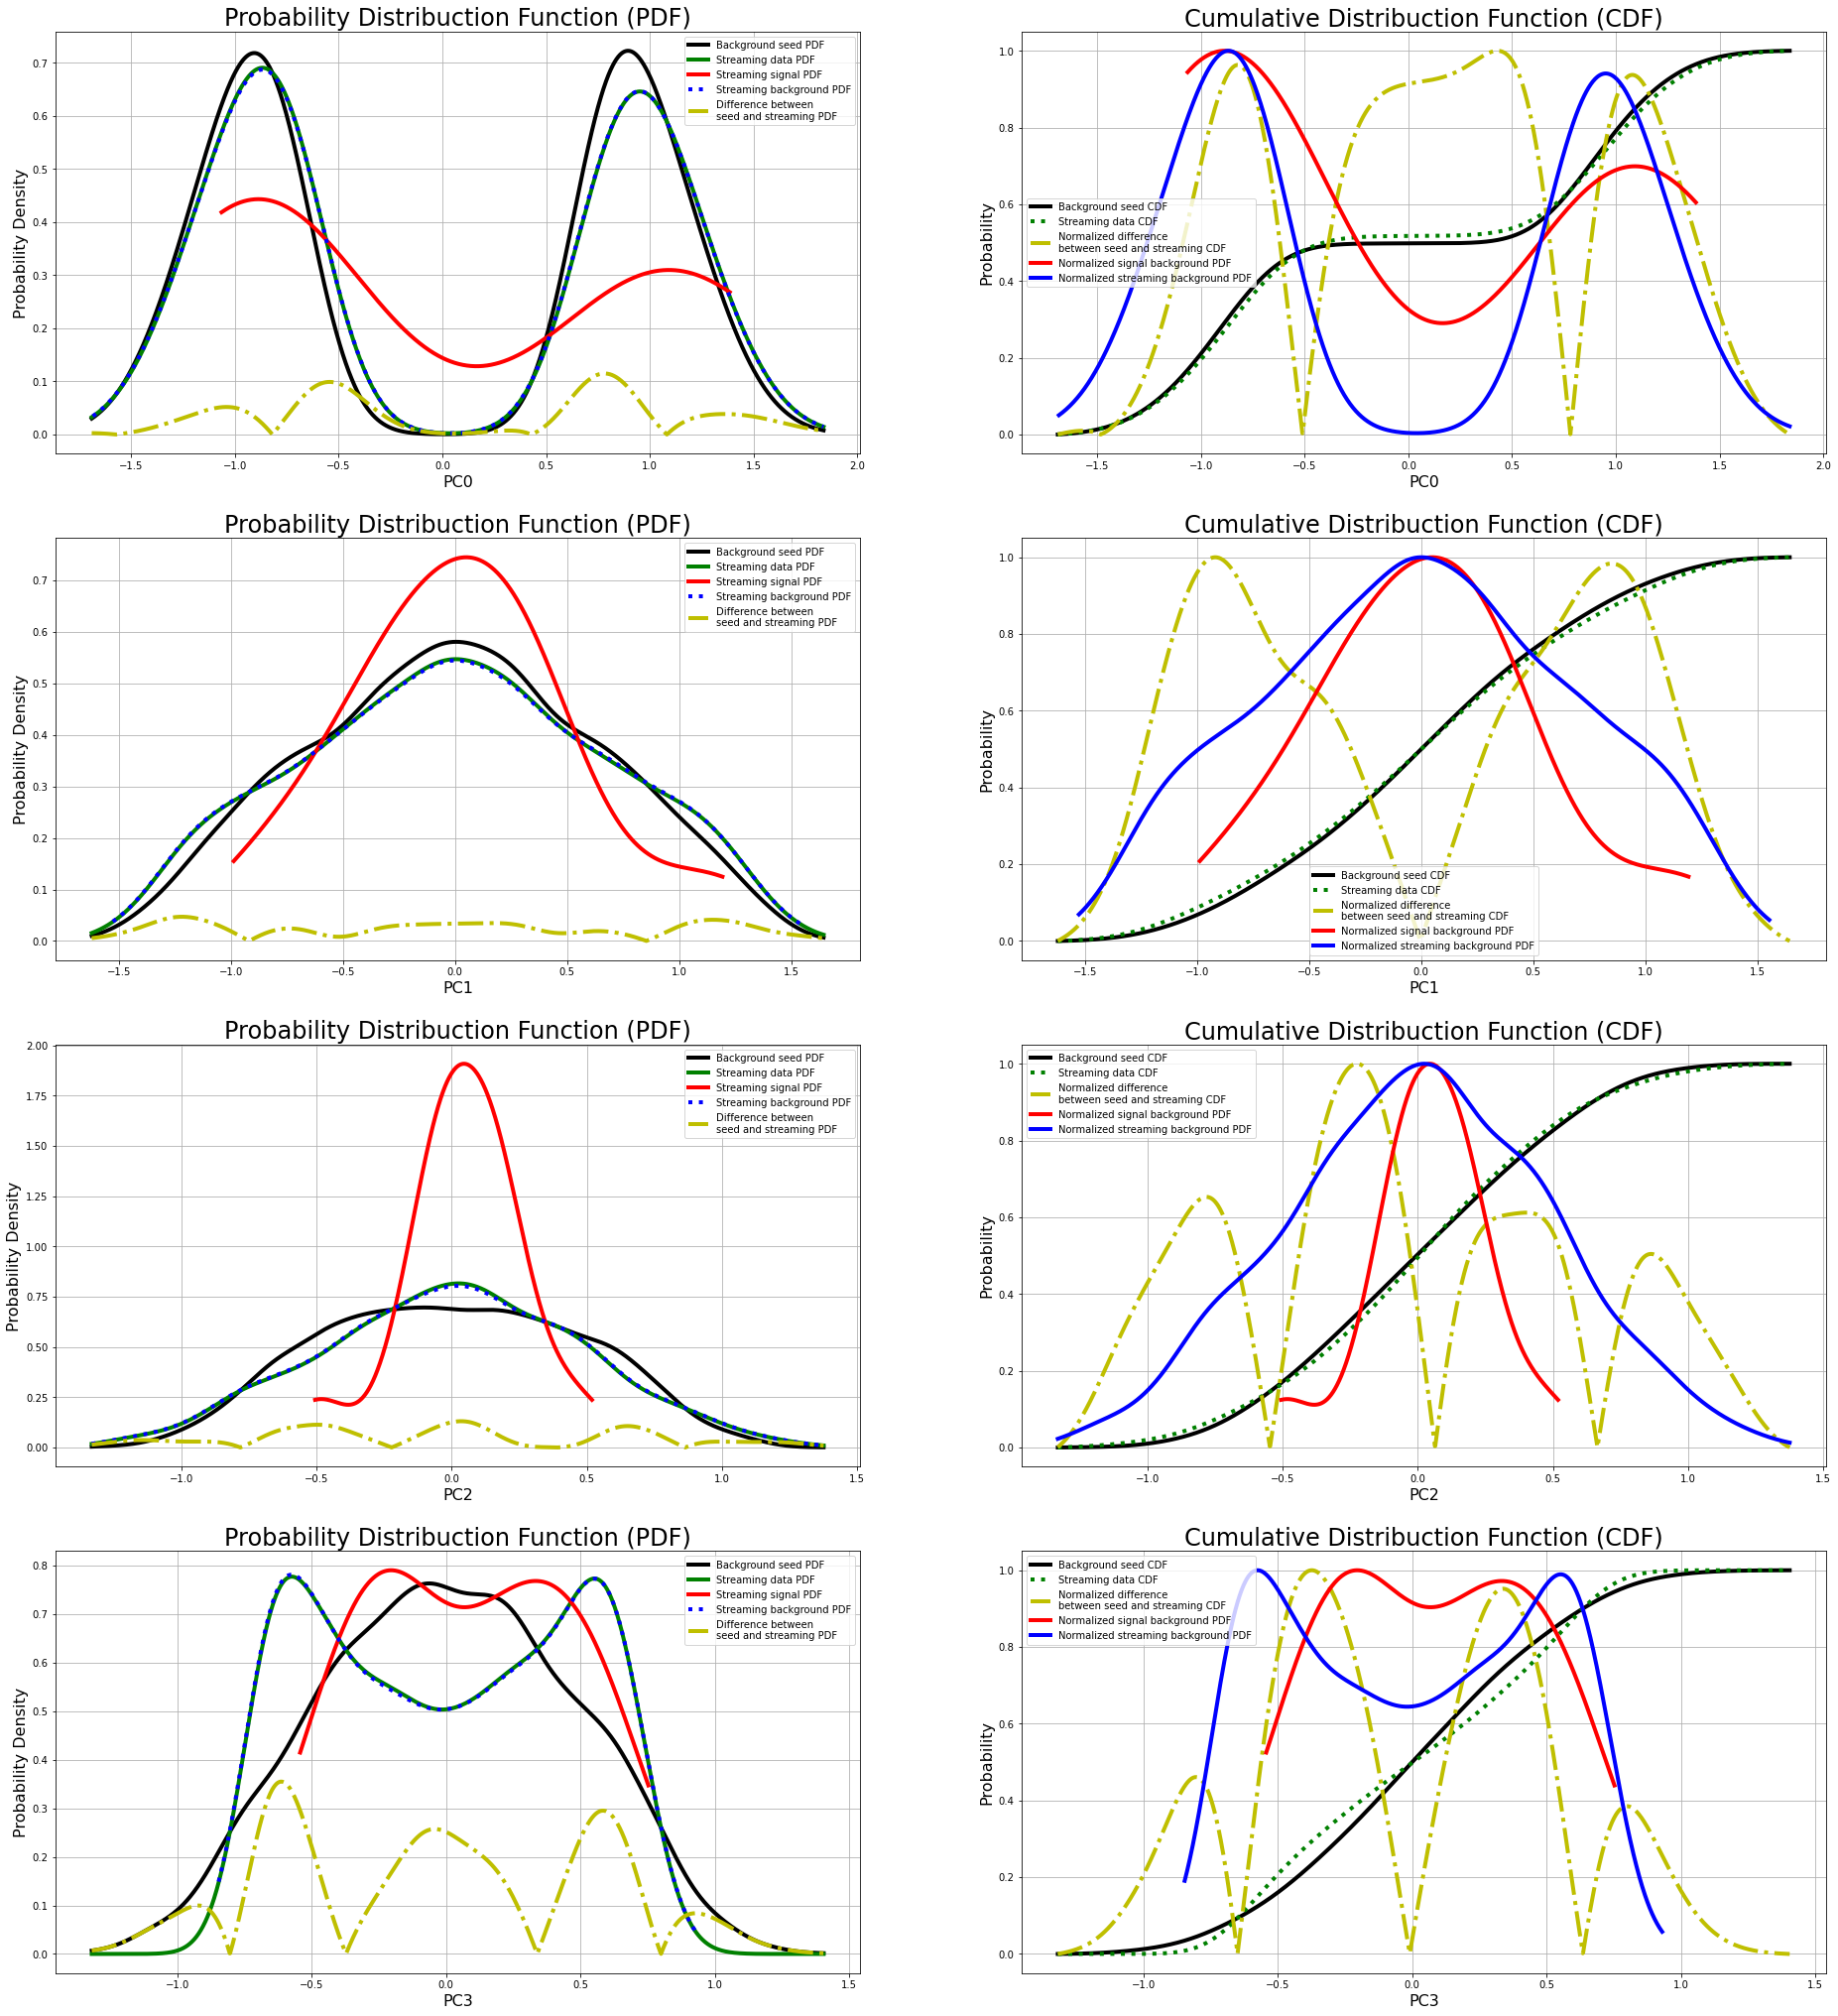

In [30]:
N_PCs = 4

norm_streaming = normalize(streaming_data,norm='max')
norm_seed = normalize(background_seed,norm='max')

streaming_pca = PCA(n_components = N_PCs)
streaming_pca.fit(norm_streaming)

seed_pca = PCA(n_components = N_PCs)
seed_pca.fit(norm_seed)

# save the model to disk
        
variacao_percentual_pca = np.round(streaming_pca.explained_variance_ratio_ * 100, decimals = 2)
        
# Now change to PCA Figures directory
        
fig = plt.figure(figsize=[16,8])
ax = fig.subplots(1,1)
ax.bar(x=['PC' + str(x) for x in range(1,(N_PCs+1))],height=variacao_percentual_pca[0:N_PCs])

ax.set_ylabel('Percentage of Variance Held',fontsize=27)
ax.set_xlabel('Principal Components',fontsize=20)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.grid()
plt.show()

print('Variation maintained: %.2f' % variacao_percentual_pca.sum())
print('                  ')

reduced_streaming = streaming_pca.transform(norm_streaming)
reduced_seed = seed_pca.transform(norm_seed)

fig = plt.figure(figsize=[32,9*N_PCs])
ax = fig.subplots(1*N_PCs,2)

for i in range(N_PCs):
    
    seed_var = reduced_seed[:,i]
    streaming_var = reduced_streaming[:,i]

    signal_streaming_var = streaming_var[n_bd_str:n_bd_str+n_sl_str]
    background_streaming_var = streaming_var[:n_bd_str]

    seed_kde = stats.gaussian_kde(seed_var)
    streaming_kde = stats.gaussian_kde(streaming_var)
    signal_kde = stats.gaussian_kde(signal_streaming_var)
    background_kde = stats.gaussian_kde(background_streaming_var)

    data_eval = np.linspace(min([min(seed_var),min(streaming_var)]),
                            max([max(seed_var),max(streaming_var)]), 
                            2000)
    background_eval = np.linspace(min(background_streaming_var),
                            max(background_streaming_var), 
                            1000)
    signal_eval = np.linspace(min(signal_streaming_var),
                            max(signal_streaming_var), 
                            1000)

    seed_cdf = pdf_to_cdf(data_eval,seed_kde)
    streaming_cdf = pdf_to_cdf(data_eval,streaming_kde)

    # Plot the Probability Distribuction Function (PDF)
    
    ax[i,0].set_ylabel('Probability Density',fontsize=16)
    ax[i,0].set_xlabel('PC'+str(i),fontsize=16)
    ax[i,0].set_title('Probability Distribuction Function (PDF)',fontsize=24)
    
    ax[i,0].plot(data_eval, seed_kde(data_eval), 'k', linewidth=4, label='Background seed PDF')
    ax[i,0].plot(data_eval, streaming_kde(data_eval),'g', linewidth=4, label='Streaming data PDF')
    ax[i,0].plot(signal_eval, signal_kde(signal_eval),'r', linewidth=4, label='Streaming signal PDF')
    ax[i,0].plot(background_eval, background_kde(background_eval),':b', linewidth=4,
                 label='Streaming background PDF')
    ax[i,0].plot(data_eval, np.sqrt((seed_kde(data_eval) - streaming_kde(data_eval))**2),'-.y', 
                 linewidth=4, label='Difference between\nseed and streaming PDF')
    ax[i,0].grid()
    ax[i,0].legend()

    # Plot the Cumulative Distribuction Function (CDF)
    
    ax[i,1].set_ylabel('Probability',fontsize=16)
    ax[i,1].set_xlabel('PC'+str(i),fontsize=16)
    ax[i,1].set_title('Cumulative Distribuction Function (CDF)',fontsize=24)
    
    ax[i,1].plot(data_eval, seed_cdf, 'k', linewidth=4, label='Background seed CDF')
    ax[i,1].plot(data_eval, streaming_cdf,':g', linewidth=4, label='Streaming data CDF')
    ax[i,1].plot(data_eval,normalize(np.sqrt((seed_cdf - streaming_cdf)**2).reshape((1,-1)),
                                        norm='max').reshape((-1))
                 ,'-.y', linewidth=4, label='Normalized difference\nbetween seed and streaming CDF')
    ax[i,1].plot(signal_eval, normalize(signal_kde(signal_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'r', linewidth=4, label='Normalized signal background PDF')
    ax[i,1].plot(background_eval, normalize(background_kde(background_eval).reshape((1,-1)),
                                        norm='max').reshape((-1)),
                 'b', linewidth=4, label='Normalized streaming background PDF')
    
    ax[i,1].grid()
    ax[i,1].legend()

plt.show()
fig.savefig('PCA_PDF&CDF.pdf', bbox_inches='tight')


In [31]:
    , label='Background seed PDF'
    , label='Streaming data PDF'
    , label='Streaming signal PDF'
    , label='Streaming background PDF'
    , label='Difference between\nseed and streaming PDF'
    
    , label='Background seed CDF'
    , label='Streaming data CDF'
    , label='Normalized difference\nbetween seed and streaming CDF'
    , label='Normalized signal background PDF'
    , label='Normalized streaming background PDF'

("label='Normalized", 'streaming', 'background', "PDF'")

# Autoencoder

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

In [33]:
def autoencoder(data, streaming=np.array([0]), reduction=9, epochs=200, batch_size=32):
    L, W = data.shape
    
    visible = Input(shape=(W,))
    e = Dense(W*2)(visible)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)

    e = Dense(W)(e)
    e = BatchNormalization()(e)
    e = LeakyReLU()(e)

    n_bottleneck = round(reduction)
    bottleneck = Dense(n_bottleneck)(e)

    d = Dense(W)(bottleneck)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    d = Dense(W*2)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU()(d)

    output = Dense(W, activation='exponential')(d)
    model = Model(inputs=visible, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(data, data, epochs=epochs, batch_size=batch_size, verbose=0)
    encoder = Model(inputs=visible, outputs=bottleneck)
    
    if streaming.any():
        reconstructed_data = model.predict(data)
        RMSE = (np.sum((data-reconstructed_data)**2,axis=1)/W)**.5
        encoded_data = encoder.predict(data)
        encoded_data = np.concatenate((encoded_data, RMSE.reshape(-1,1)), axis=1)
        
        reconstructed_streaming = model.predict(streaming)
        RMSE = (np.sum((streaming-reconstructed_streaming)**2,axis=1)/W)**.5
        encoded_streaming = encoder.predict(streaming)
        encoded_streaming = np.concatenate((encoded_streaming, RMSE.reshape(-1,1)), axis=1)
        return encoded_data, encoded_streaming
    else:
        reconstructed_data = model.predict(data)

        RMSE = (np.sum((data-reconstructed_data)**2,axis=1)/W)**.5

        encoded_data = encoder.predict(data)

        encoded_data = np.concatenate((encoded_data, RMSE.reshape(-1,1)), axis=1)
        
        return encoded_data

### Plot Distributions

In [34]:
def distribution (data, suptitle, b_sep, streaming=np.array([0])):
    L, W = data.shape
    rows = 2
    L2 = 0
       
    if streaming.any():
        b_sep = L + b_sep
        rows = 3
        data = np.concatenate((data,streaming))
        
    color = ['tab:blue', 'tab:orange']
    titles = [' - Var {}'.format(i) for i in range(1,W)] + [' - RMSE']
    
    f, ax = plt.subplots(nrows=rows, ncols=W, figsize=(W*8,rows*8), sharex='col', constrained_layout=True)
    plt.suptitle(suptitle, fontsize=50)
    for i in range(W):
        ax[0,i].hist(data[:b_sep,i], bins=400, color=color[0], density=True)
        ax[0,i].set_title('Background{}'.format(titles[i]), fontsize=30)
        
        if streaming.any():
            ax[1,i].hist(data[L:b_sep,i], bins=400, color=color[0], density=True)
            ax[1,i].set_title('Streaming Background{}'.format(titles[i]), fontsize=30)
        
        ax[-1,i].hist(data[b_sep:,i], color=color[1], density=True)
        ax[-1,i].set_title('Signal{}'.format(titles[i]), fontsize=30)
    
    plt.show()
    return f

### Plot Scatter RMSE

In [35]:
def plot_RMSE(data, b_sep):
    L, W = data.shape
    idx = list(range(L))
    
    fig = plt.figure(figsize=[10,7])
    
    plt.scatter(idx[:b_sep], data[:b_sep,-1], color='b', edgecolor='k', label='Background')
    plt.scatter(idx[b_sep:], data[b_sep:,-1], color='r', edgecolor='k', label='Signal')
    plt.title('Autoencoder Reconstruction RMSE', fontsize=15)
    plt.xlabel('Event Index', fontsize=15)
    plt.ylabel('RMSE', fontsize=15)
    plt.legend(fontsize=15)
    
    plt.show()

### Initiate Data Set

In [36]:
# Divide data-set into training and testing sub-sets
print('         .Dividing training and testing sub-sets')
b_test = int(total*background_percent)
_, divided_background = train_test_split(background, test_size=b_test/Lb)

# Defining number of events Signal events on online phase.
signal_online_samples = int(total - b_test)
_, reduced_signal = train_test_split(signal, test_size=signal_online_samples/Ls)

print('         .Selecting Signal on the following porpotion:')
print('             .{:9d} of Background samples (Online)'.format(int(b_test)) )
print('             .{:9d} of Signal samples (Online)'.format(int(signal_online_samples)))

# Concatenating Signal and the Test Background sub-set
data_raw = np.concatenate((divided_background,reduced_signal), axis=0)
print("             .Online shape: {}\n".format(data_raw.shape))

# Normalize Data
print('         .Normalizing Data')
norm = MinMaxScaler().fit(data_raw)
data = norm.transform(data_raw)

         .Dividing training and testing sub-sets
         .Selecting Signal on the following porpotion:
             .     9900 of Background samples (Online)
             .      100 of Signal samples (Online)
             .Online shape: (10000, 21)

         .Normalizing Data


In [37]:
encoded_data = autoencoder(data)

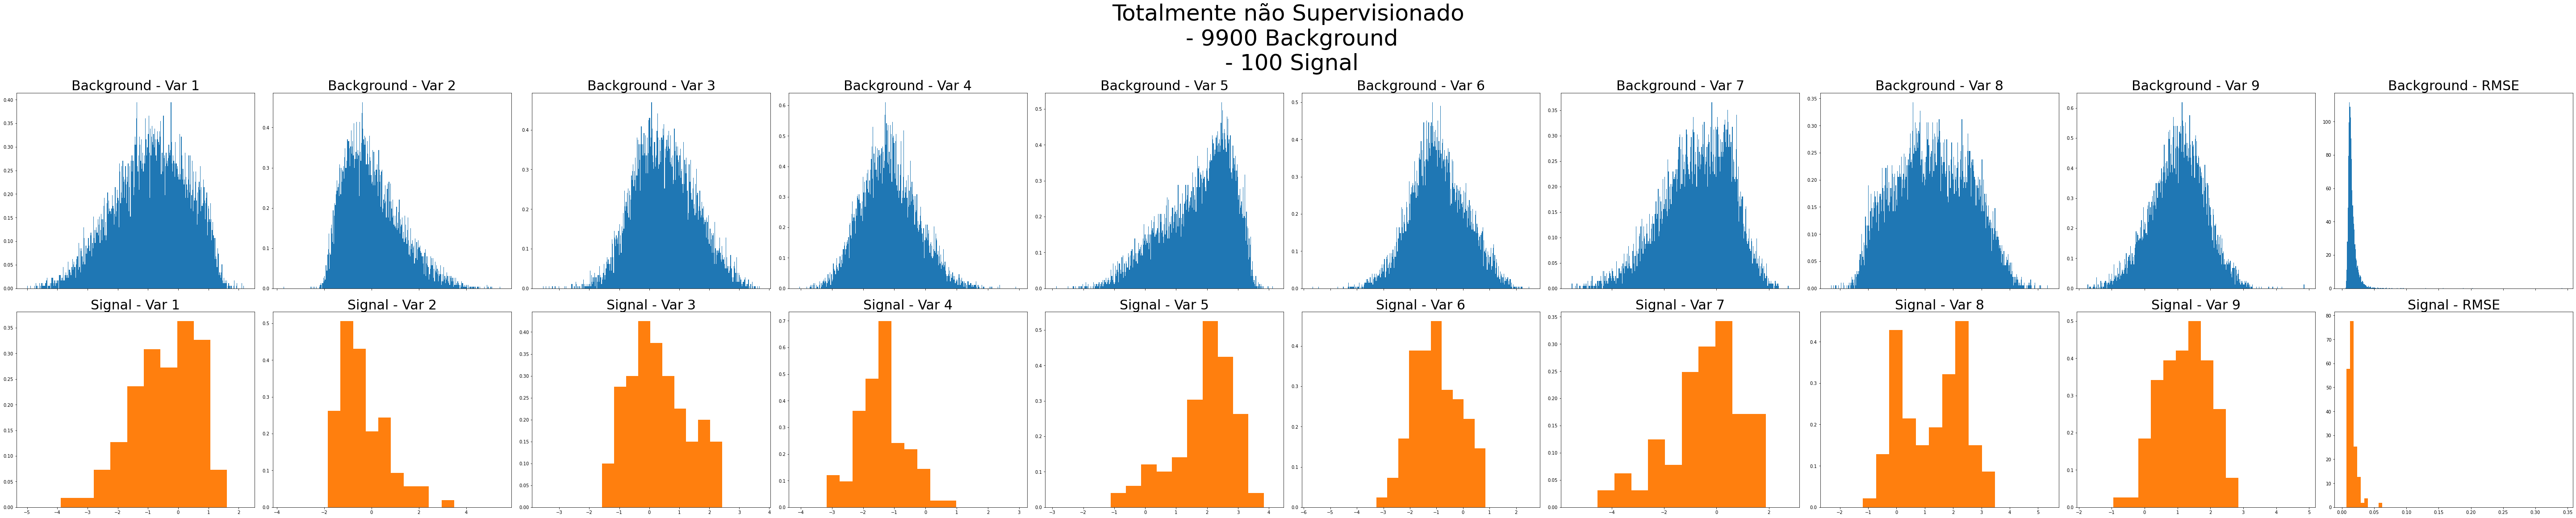

In [38]:
suptitle = 'Totalmente não Supervisionado\n - {} Background\n - {} Signal'.format(b_test, total-b_test)
fig1 = distribution(encoded_data, suptitle, b_test)

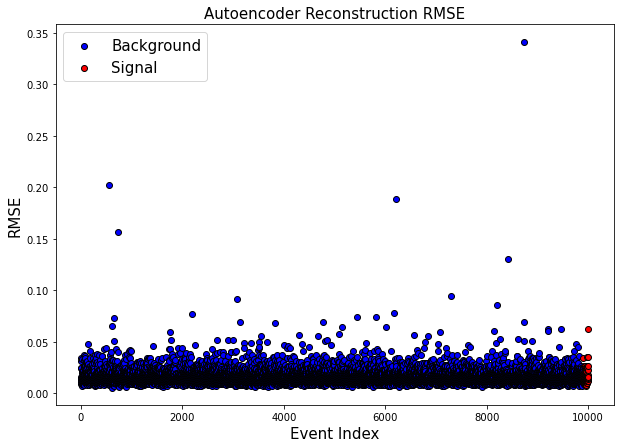

In [39]:
plot_RMSE(encoded_data, int(0.99*total))

In [42]:
def pdf_to_cdf2(var,kde):
    x_grid = np.linspace(
        min(var),
        max(var), 1000)
    kde = kde.evaluate(x_grid)
    cdf = np.cumsum(kde)
    cdf = cdf / cdf[-1]
    return x_grid,cdf

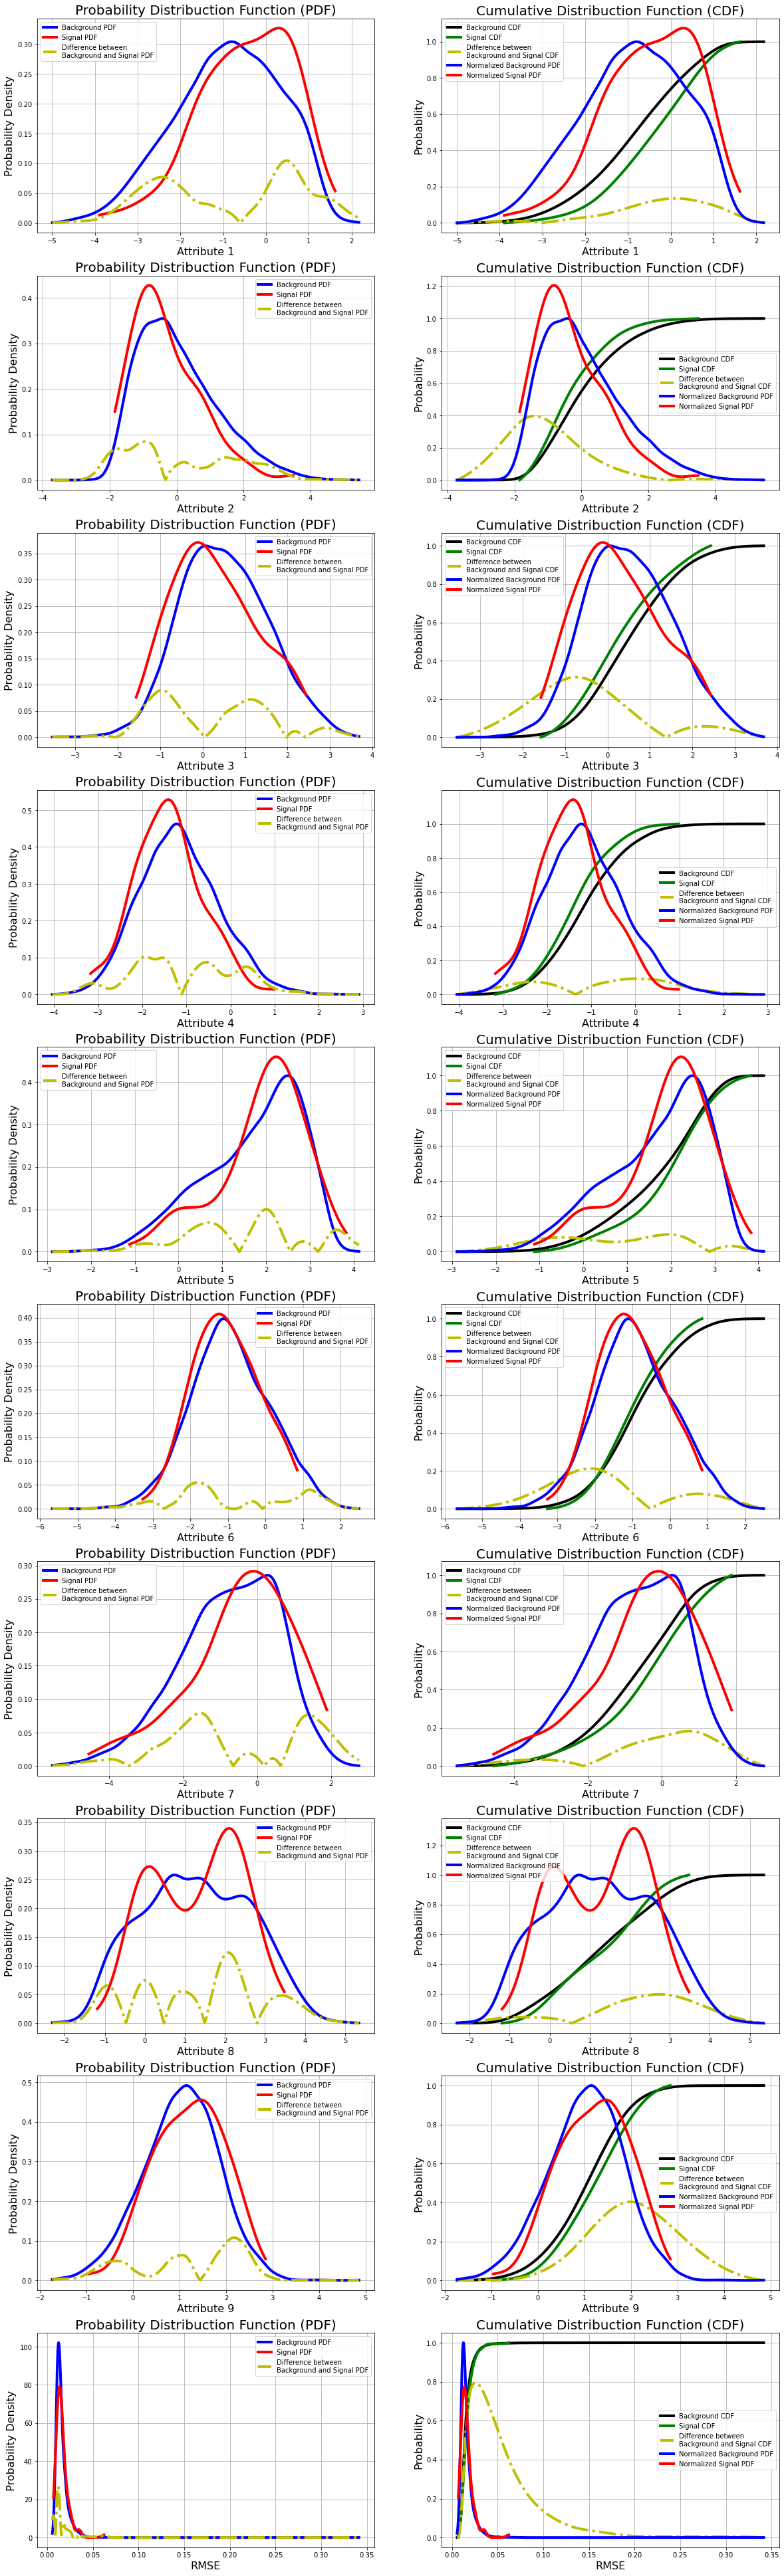

In [45]:
L, W = encoded_data.shape
xlabel = ['Attribute {}'.format(i) for i in range(1,W)] + ['RMSE']

fig = plt.figure(figsize=[20,7*W])
ax = fig.subplots(W,2)

for i in range(W):
    background_var = encoded_data[:int(0.99*total),i]
    signal_var = encoded_data[int(0.99*total):,i]

    background_kde = stats.gaussian_kde(background_var)
    signal_kde = stats.gaussian_kde(signal_var)

    back_eval,background_cdf = pdf_to_cdf2(background_var,background_kde)
    sig_eval,signal_cdf = pdf_to_cdf2(signal_var,signal_kde)

    # Plot the Probability Distribuction Function (PDF)

    ax[i,0].set_ylabel('Probability Density',fontsize=16)
    ax[i,0].set_xlabel(xlabel[i],fontsize=16)
    ax[i,0].set_title('Probability Distribuction Function (PDF)',fontsize=20)

    ax[i,0].plot(back_eval, background_kde(back_eval), 'b', linewidth=4, label='Background PDF')
    ax[i,0].plot(sig_eval, signal_kde(sig_eval),'r', linewidth=4, label='Signal PDF')
    ax[i,0].plot(back_eval, np.sqrt((signal_kde(back_eval) - background_kde(back_eval))**2),'-.y', 
                linewidth=4, label='Difference between\nBackground and Signal PDF')
    ax[i,0].grid()
    ax[i,0].legend()

    # Plot the Cumulative Distribuction Function (CDF)
    norm = MinMaxScaler().fit(background_kde(back_eval).reshape(-1, 1))
    
    ax[i,1].set_ylabel('Probability',fontsize=16)
    ax[i,1].set_xlabel(xlabel[i],fontsize=16)
    ax[i,1].set_title('Cumulative Distribuction Function (CDF)',fontsize=20)
    ax[i,1].plot(back_eval, background_cdf, 'k', linewidth=4, label='Background CDF')
    ax[i,1].plot(sig_eval, signal_cdf,'g', linewidth=4, label='Signal CDF')
    ax[i,1].plot(back_eval, np.sqrt((background_cdf - signal_cdf)**2),'-.y', 
                linewidth=4, label='Difference between\nBackground and Signal CDF')
    ax[i,1].plot(back_eval, norm.transform(background_kde(back_eval).reshape(-1, 1)), 
                 'b', linewidth=4, label='Normalized Background PDF')
    ax[i,1].plot(sig_eval, norm.transform(signal_kde(sig_eval).reshape(-1, 1)),
                 'r', linewidth=4, label='Normalized Signal PDF')
    ax[i,1].grid()
    ax[i,1].legend()

plt.show()